In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week05_explore/action_rewards.npy
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week05_explore/all_states.npy

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [1]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas

import matplotlib.pyplot as plt
%matplotlib inline

## Contents
* [1. Bernoulli Bandit](#Part-1.-Bernoulli-Bandit)
    * [Bonus 1.1. Gittins index (5 points)](#Bonus-1.1.-Gittins-index-%285-points%29.)
    * [HW 1.1. Nonstationary Bernoulli bandit](#HW-1.1.-Nonstationary-Bernoulli-bandit)
* [2. Contextual bandit](#Part-2.-Contextual-bandit)
    * [2.1 Bulding a BNN agent](#2.1-Bulding-a-BNN-agent)
    * [2.2 Training the agent](#2.2-Training-the-agent)
    * [HW 2.1 Better exploration](#HW-2.1-Better-exploration)
    * [Bonus 3.2 Bootstrapped DQN (10 points)](#Bonus-3.2-Bootstrapped-DQN-%2810-points%29)


## Part 1. Bernoulli Bandit

We are going to implement several exploration strategies for simplest problem - bernoulli bandit.

The bandit has $K$ actions. Action produce 1.0 reward $r$ with probability $0 \le \theta_k \le 1$ which is unknown to agent, but fixed over time. Agent's objective is to minimize regret over fixed number $T$ of action selections:

$$\rho = T\theta^* - \sum_{t=1}^T r_t$$

Where $\theta^* = \max_k\{\theta_k\}$

**Real-world analogy:**

Clinical trials - we have $K$ pills and $T$ ill patient. After taking pill, patient is cured with probability $\theta_k$. Task is to find most efficient pill.

A research on clinical trials - https://arxiv.org/pdf/1507.08025.pdf

In [ ]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        if np.any(np.random.random() > self._probs[action]):
            return 0.0
        return 1.0

    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self._probs)

    def step(self):
        """ Used in nonstationary version
        """
        pass

    def reset(self):
        """ Used in nonstationary version
        """

In [ ]:
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass

    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):
    def get_action(self):
        return np.random.randint(0, len(self._successes))

### Epsilon-greedy agent

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; $x_t \leftarrow argmax_{k}\hat\theta$ with probability $1 - \epsilon$ or random action with probability $\epsilon$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

Implement the algorithm above in the cell below:

In [ ]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.01):
        self._epsilon = epsilon

    def get_action(self):
        if np.random.rand() < self._epsilon: return np.random.randint(0, len(self._successes)) 
        return np.argmax(self._successes / (self._successes + self._failures + 1e-5))

    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

### UCB Agent
Epsilon-greedy strategy have no preference for actions. It would be better to select among actions that are uncertain or have potential to be optimal. One can come up with idea of index for each action that represents optimality and uncertainty at the same time. One efficient way to do it is to use UCB1 algorithm:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2\log(t) \ / \ (\alpha_k + \beta_k)}$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; **end for** 
 $x_t \leftarrow argmax_{k}w$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**

__Note:__ in practice, one can multiply $\sqrt{2\log(t) \ / \ (\alpha_k + \beta_k)}$ by some tunable parameter to regulate agent's optimism and wilingness to abandon non-promising actions.

More versions and optimality analysis - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf

In [ ]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        return np.argmax(self._successes / (self._successes + self._failures + 1e-5) +\
                         np.sqrt(2 * np.log1p(self._total_pulls) / (self._successes + self._failures + 1e-5)))

### Thompson sampling

UCB1 algorithm does not take into account actual distribution of rewards. If we know the distribution - we can do much better by using Thompson sampling:

**for** $t = 1,2,...$ **do**

&nbsp;&nbsp; **for** $k = 1,...,K$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample $\hat\theta_k \sim beta(\alpha_k, \beta_k)$

&nbsp;&nbsp; **end for** 

&nbsp;&nbsp; $x_t \leftarrow argmax_{k}\hat\theta$

&nbsp;&nbsp; Apply $x_t$ and observe $r_t$

&nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

**end for**
 

More on Thompson Sampling:
https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

In [ ]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
        return np.argmax(np.random.beta(self._successes + 1., self._failures + 1.))


In [ ]:
from collections import OrderedDict

def get_regret(env, agents, n_steps=5000, n_trials=50):
    scores = OrderedDict({
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    })

    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  # change bandit's state if it is unstationary

    for agent in agents:
        scores[agent.name] = np.cumsum(scores[agent.name]) / n_trials

    return scores

def plot_regret(agents, scores):
    for agent in agents:
        plt.plot(scores[agent.name])

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

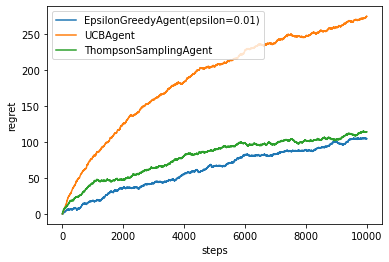

In [ ]:
# Uncomment agents
agents = [
        EpsilonGreedyAgent(),
        UCBAgent(),
        ThompsonSamplingAgent()
]

regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)
plot_regret(agents, regret)

# Bonus 1.1. Gittins index (5 points).

Bernoulli bandit problem has an optimal solution - Gittins index algorithm. Implement finite horizon version of the algorithm and demonstrate it's performance with experiments. Some articles:
- Wikipedia article - https://en.wikipedia.org/wiki/Gittins_index
- Different algorithms for index computation - http://www.ece.mcgill.ca/~amahaj1/projects/bandits/book/2013-bandit-computations.pdf (see "Bernoulli" section)
    

In [ ]:
class GittinsIndexAgent(AbstractAgent):
    """
      Based on https://arxiv.org/pdf/1909.05075.pdf
    """
    def __init__(self, horizon: float = 50, discount_factor: float = .99) -> None:
        """
        args:
          horizon: float, lookahead horizon
          discount_factor: float
        """
        self.l = horizon
        self.gamma = discount_factor

        self.lb = 0; self.ub = 1 #bounds for reward
        self.gi = None #gittins index
        self.eps = 0.001 ## epsilon for index calculations

    def reset(self) -> None:
        self._successes = np.ones_like(self._successes, dtype = np.float32) 
        self._failures = np.ones_like(self._failures, dtype = np.float32)
        self._total_pulls = 0

    def value_func(self, p: np.ndarray, q: np.ndarray, lambda_: float) -> float:
        """
            args:
              p, float np.ndarray: #successes
              q, float np.ndarray: #failrues
              lambda_, float: safe arm (known fixed reward)
        """
        V = np.zeros((self.l + 1, self.l + 1))
        p_ = np.arange(0, self.l + 1)
        q_ = self.l - p_

        V[p_, q_] = self.gamma**(self.l - 1) / (1 - self.gamma) *\
                   np.maximum((p + p_) / (p + p_ + q + q_ + 1e-5) - lambda_, 0)
        
        for iter_ in range(self.l - 1, -1, -1):
            p_ = np.arange(0, iter_ + 1)
            q_ = iter_ - p_
            succ_prob = (p + p_) / (p + p_ + q + q_ + 1e-5)
            failure_prob = 1 - succ_prob
            V[p_, q_] = np.maximum(succ_prob - lambda_ + self.gamma *\
                                 (succ_prob * V[p_ + 1, q_] + failure_prob * V[p_, q_ + 1]), #?
                                  0)
        return V[0,  0]
    
    def update(self, action, reward) -> None:
        def get_gittins_index(p: np.ndarray, q: np.ndarray) -> float:
          """Calibration for Gittins indices"""
          u = self.ub; l = self.lb
          while u - l > self.eps:
              lambda_ = .5 * (u + l)
              V = self.value_func(p, q, lambda_)
              if V > 0: l = lambda_
              else: u = lambda_
          return (u + l) * .5

        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

        ## smoothing agents that doesn't have successes or failures    
        p = self._successes[action] + 1.
        q = self._failures[action] + 1.
        
        ## update gittins index 
        if self.gi is None: self.gi = np.zeros(len(self._successes))
        self.gi[action] = get_gittins_index(p, q)

    def get_action(self) -> int:
        return np.argmax(np.random.beta(self._successes + 1., self._failures + 1.))

    @property
    def name(self):
        return self.__class__.__name__ + "(Gittins index: gamma = {}, L = {})".format(self.gamma, self.l)

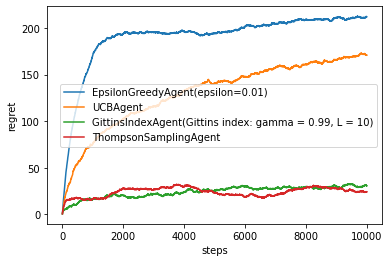

In [ ]:
agents = [
        EpsilonGreedyAgent(),
        UCBAgent(),
        GittinsIndexAgent(horizon=10),
        ThompsonSamplingAgent()
]

regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)
plot_regret(agents, regret)

# HW 1.1. Nonstationary Bernoulli bandit

What if success probabilities change over time? Here is an example of such bandit:

In [ ]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, n_actions=5, gamma=0.01):
        """
        Idea from https://github.com/iosband/ts_tutorial
        """
        super().__init__(n_actions)

        self._gamma = gamma

        self._successes = None
        self._failures = None
        self._steps = 0

        self.reset()

    def reset(self):
        self._successes = np.zeros(self.action_count) + 1.0
        self._failures = np.zeros(self.action_count) + 1.0
        self._steps = 0

    def step(self):
        action = np.random.randint(self.action_count)
        reward = self.pull(action)
        self._step(action, reward)

    def _step(self, action, reward):
        self._successes = self._successes * (1 - self._gamma) + self._gamma
        self._failures = self._failures * (1 - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1.0 - reward

        self._probs = np.random.beta(self._successes, self._failures)

And a picture how it's reward probabilities change over time

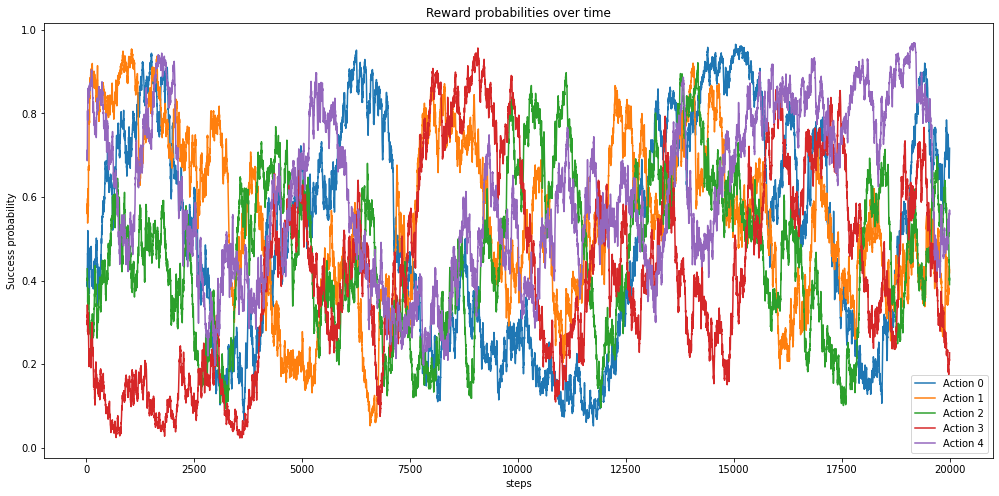

In [ ]:
drifting_env = DriftingBandit(n_actions=5)

drifting_probs = []
for i in range(20000):
    drifting_env.step()
    drifting_probs.append(drifting_env._probs)

plt.figure(figsize=(17, 8))
plt.plot(pandas.DataFrame(drifting_probs).rolling(window=20).mean())

plt.xlabel("steps")
plt.ylabel("Success probability")
plt.title("Reward probabilities over time")
plt.legend(["Action {}".format(i) for i in range(drifting_env.action_count)])
plt.show()

Your task is to invent an agent that will have better regret than stationary agents from above.

In [ ]:
# YOUR AGENT HERE SECTION
class MyAgent(AbstractAgent):
    def __init__(self, reset_rate = 500):
        self.reset_rate = reset_rate
    def get_action(self):
        if self._total_pulls % self.reset_rate == 0:
            self._successes = np.ones_like(self._successes, dtype = np.float32) 
            self._failures = np.ones_like(self._failures, dtype = np.float32)
        return np.argmax(np.random.beta(self._successes + 1., self._failures + 1.))

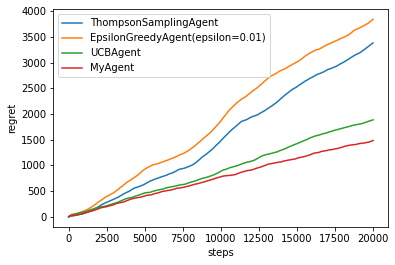

In [ ]:
drifting_agents = [
    ThompsonSamplingAgent(),
    EpsilonGreedyAgent(),
    UCBAgent(),
    MyAgent(reset_rate = 1000)
]

regret = get_regret(DriftingBandit(), drifting_agents, n_steps=20000, n_trials=10)
plot_regret(drifting_agents, regret)

## Part 2. Contextual bandit (Associative search)

So far we considered nonassociative bandits - that is, we had no need to associate different actions with different environment states. In a general reinforcement learning there is more than one state, and the goal
is to learn a policy: a mapping from states to the actions that are best in those
states.

The simplest way in which nonassociative tasks can extend to the associative setting is called contextual bandits. In such task an agent at each step is provided with a state on which reward distribution of actions may depend. For example, consider a task where you have several different k-armed bandits and on each step your agent is provided with an id of current bandit.

**Real-word analogy:**
> Contextual advertising. We have a lot of banners and a lot of different users. Users can have different features: age, gender, search requests. We want to show banner with highest click probability.

**Question:** What is the difference between contextual bandits and full reinforcement learning task?

If we want use strategies from above, we need somehow store reward distributions conditioned both on actions and bandit's state. 
One way to do this - use bayesian neural networks. Instead of giving pointwise estimates of target, they maintain probability distributions

<img src="https://github.com/yandexdataschool/Practical_RL/blob/master/week05_explore/bnn.png?raw=1">
Picture from https://arxiv.org/pdf/1505.05424.pdf

## 2.1 Making bayesian neural network


Code and formulas come from this [post](https://www.ritchievink.com/blog/2019/09/16/variational-inference-from-scratch/). You can read more on theory in this [paper](https://arxiv.org/abs/1505.05424).

### 2.1.1 Some theory
We have data $D$ and model some model parameters $Z$. In the process of model fitting we want to get posterior distribution of model parameters, i.e. $P(Z | D)$. We can use Bayes rule:

$$ P(Z | D) = \frac{P(D|Z)P(Z)}{P(D)}$$

Where $P(D|Z)$ is likelihood, $P(Z)$ - prior distribution of model parameters, $P(D)$ - probability of obtaining data from our model family.

Direct computation of $P(Z | D)$ is intractable, so we will replace it with variational distribution $Q(Z)$ parametrized by $\Theta$ and our learning process will minimize $D_{KL}(Q(Z | \Theta)||P(Z | D))$ with $\Theta$ as parameter.

$$D_{KL}(Q(Z)||P(Z|D)) = \int_{Z}Q(Z) log\frac{Q(Z)}{P(Z|D)}dZ$$

Rewrite posterior:

$$D_{KL} = \int_{Z}Q(Z) log\frac{Q(Z)P(D)}{P(Z,D)}dZ$$

Apply logarithm modification rule:
$$D_{KL} = \int_{Z}Q(Z) log\frac{Q(Z)}{P(Z,D)}dZ + \int_{Z}Q(Z) logP(D)dZ$$

As $P(D)$ is not parametrized by $Z$ we can rewrite:
$$D_{KL} = \int_{Z}Q(Z) log\frac{Q(Z)}{P(Z,D)}dZ + logP(D)$$

We do not care about $logP(D)$ because it does not depend on parameters. So we need to optimize only first part of sum which is called ELBO.
$$ELBO = E_{Z \sim Q}[Q(Z) log\frac{P(Z,D)}{Q(Z)}]$$

Now, rewriting First we rewrite the joint probability $P(Z,D)$ into conditional probability $P(D|Z)P(Z)$ and applying logarithmic rule we have:

$$ELBO = E_{Z \sim Q}[logP(D|Z)] + E_{Z \sim Q}[log\frac{P(Z)}{Q(Z)}]$$

If we rewrite second term in integral form:

$$ELBO = E_{Z \sim Q}[logP(D|Z)] - D_{KL}(Q(Z)||P(Z))$$

First term is likelihood of data being received from our model and second term is called reconstruction error.

### 2.1.2 The model

We will model weights of our neural network with normal distribution. Our prior and likelihood:

$$w \sim N(0, 1)$$
$$y \sim P(y|x, w)$$

Our variational distribution is

$$w \sim N(\mu_w, \sigma_w ^ 2)$$

And variational parameters are $\Theta = (\mu_w, \sigma_w)$

**Reparametrization trick**

We cannot backpropagate directly throw $w \sim N(\mu_w, \sigma_w ^ 2)$, so we rewrite this function as

$$w = \mu + \sigma * \epsilon$$

$$\epsilon \sim N(0,1)$$

We will also model $\sigma_w$ as $log(1 + e^{p_w})$ to be able to optimize throw it without constraints.

Let's code it up:

In [2]:
import torch
from torch import nn

def reparameterize(mu, p):
    sigma = torch.log(1 + torch.exp(p))
    eps = torch.randn_like(sigma)
    return mu + (eps * sigma)

Next, implement KL divergence $D_{KL}(Q(Z)||P(Z)$ in expectation form:

In [3]:
def kl_divergence(z, mu_theta, p_theta):
    log_prior = torch.distributions.Normal(0, 1).log_prob(z) 
    log_p_q = torch.distributions.Normal(mu_theta, torch.log(1 + torch.exp(p_theta))).log_prob(z) 
    return (log_p_q - log_prior).sum()

No we can implement full bayesian layer

In [4]:
class LinearVariational(nn.Module):
    def __init__(self, in_features, out_features, parent, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.include_bias = bias        
        self.parent = parent
        
        if getattr(parent, 'accumulated_kl_div', None) is None:
            if getattr(parent.parent, 'accumulated_kl_div', None) is None:
                parent.accumulated_kl_div = 0
            else:
                parent.accumulated_kl_div = parent.parent.accumulated_kl_div
            
        # Initialize the variational parameters.
        # 𝑄(𝑤)=N(𝜇_𝜃,𝜎2_𝜃)
        # Do some random initialization with 𝜎=0.001
        self.w_mu = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=0, std=0.001)
        )
        # proxy for variance
        # log(1 + exp(ρ))◦ eps
        self.w_p = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=-3, std=0.001)
        )
        if self.include_bias:
            self.b_mu = nn.Parameter(
                torch.zeros(out_features)
            )
            # proxy for variance
            self.b_p = nn.Parameter(
                torch.zeros(out_features)
            )

    def forward(self, x):
        w = reparameterize(self.w_mu, self.w_p)
        
        if self.include_bias:
            b = reparameterize(self.b_mu, self.b_p)
        else:
            b = 0
            
        z = x @ w + b
        
        self.parent.accumulated_kl_div += kl_divergence(w, self.w_mu, self.w_p)
        if self.include_bias:
            self.parent.accumulated_kl_div += kl_divergence(b, self.b_mu, self.b_p)
        return z

And simple model

In [5]:
class KL:
    accumulated_kl_div = 0

class Model(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.kl_loss = KL
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, hidden_size, self.kl_loss),
            nn.ReLU(),
            LinearVariational(hidden_size, hidden_size, self.kl_loss),
            nn.ReLU(),
            LinearVariational(hidden_size, out_size, self.kl_loss)
        )
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0
            
    def forward(self, x):
        return self.layers(x)

Finall loss

In [6]:
def det_loss(y, y_pred, model):
    batch_size = y.shape[0]
    reconstruction_error = -torch.distributions.Normal(y_pred, .1).log_prob(y).sum()
    kl = model.accumulated_kl_div
    model.reset_kl_div()
    return reconstruction_error + kl

Toy experiment

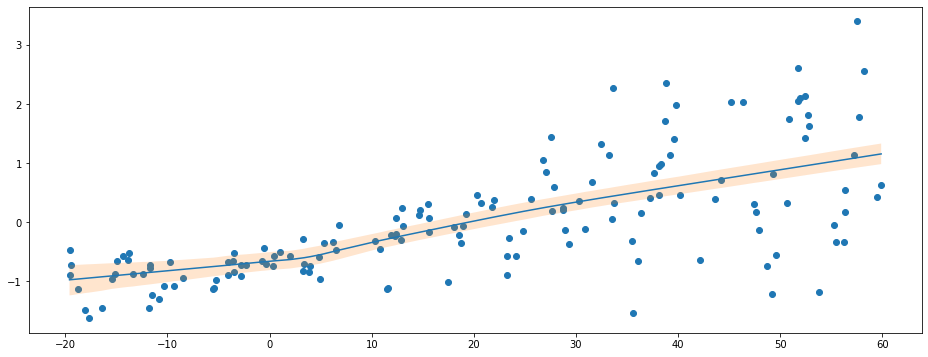

In [7]:
import numpy as np
import torch
from torch import nn
from sklearn import datasets
import matplotlib.pyplot as plt


# Generate dataset
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

y, x = load_dataset()


# Fit the model
X = torch.tensor(x, dtype=torch.float)
Y = torch.tensor(y, dtype=torch.float)


epochs = 2000
m = Model(1, 20, 1)
optim = torch.optim.Adam(m.parameters(), lr=0.01)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = det_loss(y_pred, Y, m)
    loss.backward()
    optim.step()

# Sample predictions from model and draw quantiles
with torch.no_grad():
    trace = np.array([m(X).flatten().numpy() for _ in range(1000)]).T

q_25, q_95 = np.quantile(trace, [0.05, 0.95], axis=1)
plt.figure(figsize=(16, 6))
plt.plot(X, trace.mean(1))
plt.scatter(X, Y)
plt.fill_between(X.flatten(), q_25, q_95, alpha=0.2)
plt.show()

###  2.1.3 The bandit

Load dataset for bandit simulation:

In [8]:
all_states = np.load("all_states.npy")
action_rewards = np.load("action_rewards.npy")

state_size = all_states.shape[1]
n_actions = action_rewards.shape[1]

print("State size: %i, actions: %i" % (state_size, n_actions))

State size: 60, actions: 10


Dataset consists of state vectors and reward vectors which contain reward for each state. 
Reward distribution on arms depends on state vector.

$\epsilon$-greedy contextual bandit:

1. Sample a new set of parameters from the model
2. With probability $\epsilon$ pick random action, with probability $(1 - \epsilon)$ pick action with best expected reward.
3. Update the model, go to 1


Let's make an agent:

In [9]:
class BNNAgent(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()

        self.out_size = out_size
        self.kl_loss = KL
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, hidden_size, self.kl_loss),
            nn.Tanh(),
            LinearVariational(hidden_size, hidden_size, self.kl_loss),
            nn.Tanh(),
            LinearVariational(hidden_size, out_size, self.kl_loss)
        )
        
        self.epsilon = .25
            
    def forward(self, x):
        return self.layers(x)
    
    def sample_prediction(self, states, n_samples=1):
        return np.stack([
            self(torch.Tensor(states)).detach().numpy() 
            for _ in range(n_samples)])
    
    def get_action(self, states):
        n_samples = 100
        
        reward_samples = self.sample_prediction(states, n_samples=n_samples)
        best_actions = reward_samples.mean(axis=0).argmax(axis=-1)
        random_actions = np.random.randint(0, self.out_size, len(states))
        
        chosen_actions = np.array(
            [
                random_actions[i] if np.random.random() < self.epsilon 
                else a for i, a in enumerate(best_actions)
            ]
        )
        
        return chosen_actions
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0

In [14]:
from IPython.display import clear_output

from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values


def get_new_samples(states, action_rewards, batch_size=8):
    """samples random minibatch, emulating new users"""
    batch_ix = np.random.randint(0, len(states), batch_size)
    return states[batch_ix], action_rewards[batch_ix]


def train_contextual_agent(agent, batch_size=32, n_iters=100):
    total_samples = 0
    optim = torch.optim.Adam(agent.parameters(), lr=0.01)
    
    rewards_history = []
    
    for i in range(n_iters):
        # Sample batch of bandit states
        b_states, b_action_rewards = get_new_samples(all_states, action_rewards, batch_size)
        
        # Get actions from bandit
        b_actions = agent.get_action(b_states)
        
        # Get rewards
        b_rewards = b_action_rewards[np.arange(batch_size), b_actions]
        
        mse, kl = 0, 0
        
        # Update model
        for _ in range(25):
            optim.zero_grad()

            action_preds = agent.forward(torch.Tensor(b_states))  
            y = action_preds.gather(1, torch.LongTensor([b_actions]).T).T[0]
            
            # loglikelihood can be replaced with mse loss for normal distributions
            loss = ((torch.Tensor(b_rewards) - y)**2).sum()
            loss += agent.accumulated_kl_div / (total_samples + batch_size)
            
            kl += agent.accumulated_kl_div / (total_samples + batch_size)
            mse += loss

            loss.backward()
            agent.reset_kl_div()
            optim.step()            

        rewards_history.append(b_rewards.mean())
        total_samples += batch_size
        
        # Plot some graphs
        if i % 10 == 0:
            clear_output(True)
            print("iteration #%i\tmean reward=%.3f\tmse=%.3f\tkl=%.3f" %
                  (i, np.mean(rewards_history[-10:]), mse, kl))
            plt.plot(rewards_history)
            plt.plot(moving_average(np.array(rewards_history), alpha=0.1))
            plt.title("Reward per epesode")
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.show()

            samples = agent.sample_prediction(
                b_states[:1], n_samples=100).T[:, 0, :]
            for i in range(len(samples)):
                plt.hist(samples[i], alpha=0.25, label=str(i))
                plt.legend(loc='best')
            print('Q(s,a) std:', ';'.join(
                list(map('{:.3f}'.format, np.std(samples, axis=1)))))
            print('correct', b_action_rewards[0].argmax())
            print('rewards', b_action_rewards[0])
            plt.title("p(Q(s, a))")
            plt.show()

    return moving_average(np.array(rewards_history), alpha=0.1)

iteration #490	mean reward=0.663	mse=70.596	kl=28.508


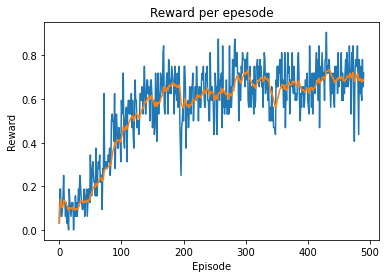

Q(s,a) std: 0.084;0.143;0.087;0.072;0.083;0.062;0.105;0.098;0.311;0.086
correct 8
rewards [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


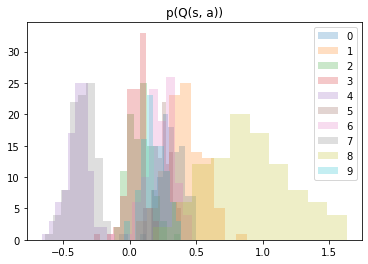

In [15]:
N_ITERS=500
agent = BNNAgent(in_size=state_size, hidden_size=32, out_size=n_actions)
greedy_agent_rewards = train_contextual_agent(agent, batch_size=32, n_iters=N_ITERS)

## HW 2.1 Better exploration

Use strategies from first part to gain more reward in contextual setting

In [22]:
class ThompsonBNNAgent(BNNAgent):
    def get_action(self, states):
        """
        picks action based by taking _one_ sample from BNN and taking action with highest sampled reward (yes, that simple)
        This is exactly thompson sampling.
        """

        n_samples = 1
        reward_samples = self.sample_prediction(states, n_samples=n_samples)
        chosen_action = reward_samples.mean(axis = 0).argmax(axis = -1)
        return chosen_action

iteration #490	mean reward=0.822	mse=19.986	kl=8.243


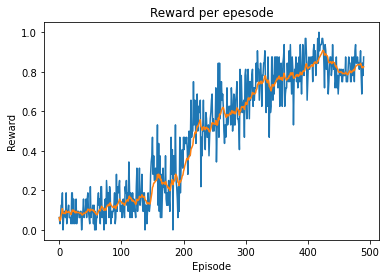

Q(s,a) std: 0.058;0.086;0.049;0.085;0.054;0.050;0.050;0.067;0.061;0.066
correct 1
rewards [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


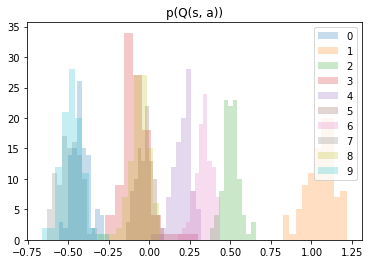

In [23]:
thompson_agent_rewards = train_contextual_agent(ThompsonBNNAgent(in_size=state_size, hidden_size=32, out_size=n_actions),
                                               batch_size=32, n_iters= N_ITERS)

In [24]:
class BayesUCBBNNAgent(BNNAgent):
    def get_action(self, states):
        """
        Compute q-th percentile of rewards P(r|s,a) for all actions
        Take actions that have highest percentiles.

        This implements bayesian UCB strategy
        """
        q = 95
        n_samples = 10
        reward_samples = np.percentile(self.sample_prediction(states, n_samples=n_samples), q, axis = 0)
        chosen_actions = reward_samples.argmax(axis=-1)
        return chosen_actions
    

iteration #490	mean reward=0.819	mse=53.760	kl=10.624


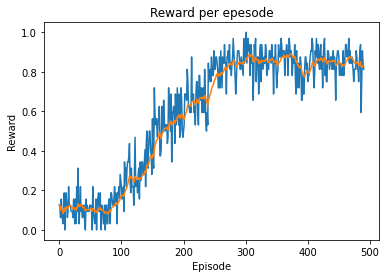

Q(s,a) std: 0.041;0.056;0.038;0.054;0.107;0.043;0.042;0.076;0.205;0.056
correct 9
rewards [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


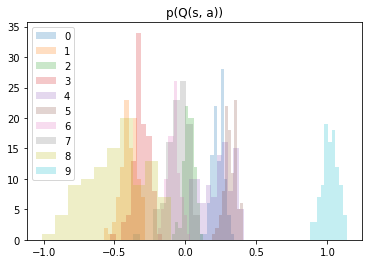

In [25]:
ucb_agent_rewards = train_contextual_agent(BayesUCBBNNAgent(in_size=state_size, hidden_size=32, out_size=n_actions),
                                               batch_size=32, n_iters= N_ITERS)

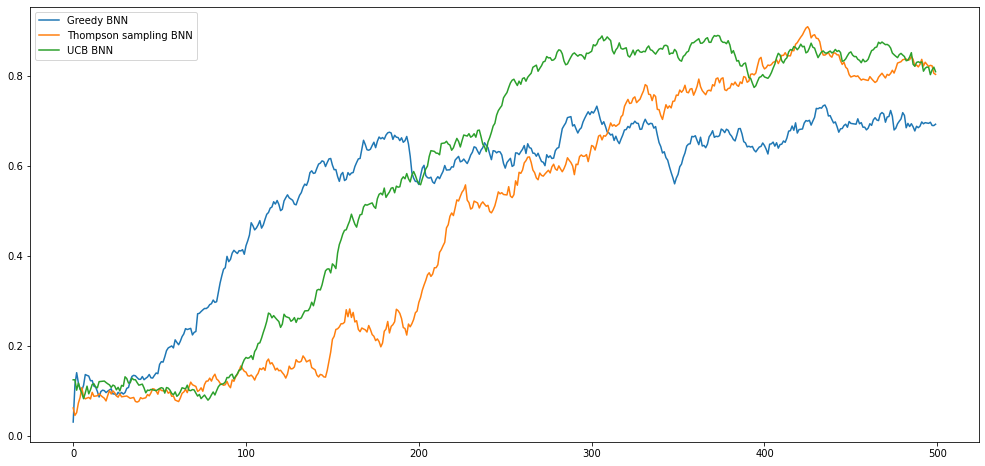

In [26]:
plt.figure(figsize=(17, 8))

plt.plot(greedy_agent_rewards)
plt.plot(thompson_agent_rewards)
plt.plot(ucb_agent_rewards)

plt.legend([
    "Greedy BNN",
    "Thompson sampling BNN",
    "UCB BNN"
])

plt.show()

## Bonus 3.2 Bootstrapped DQN (10 points)

Implement Bootstrapped DQN algorithm and compare it's performance with ordinary DQN on BeamRider Atari game. Links:
- https://arxiv.org/abs/1602.04621